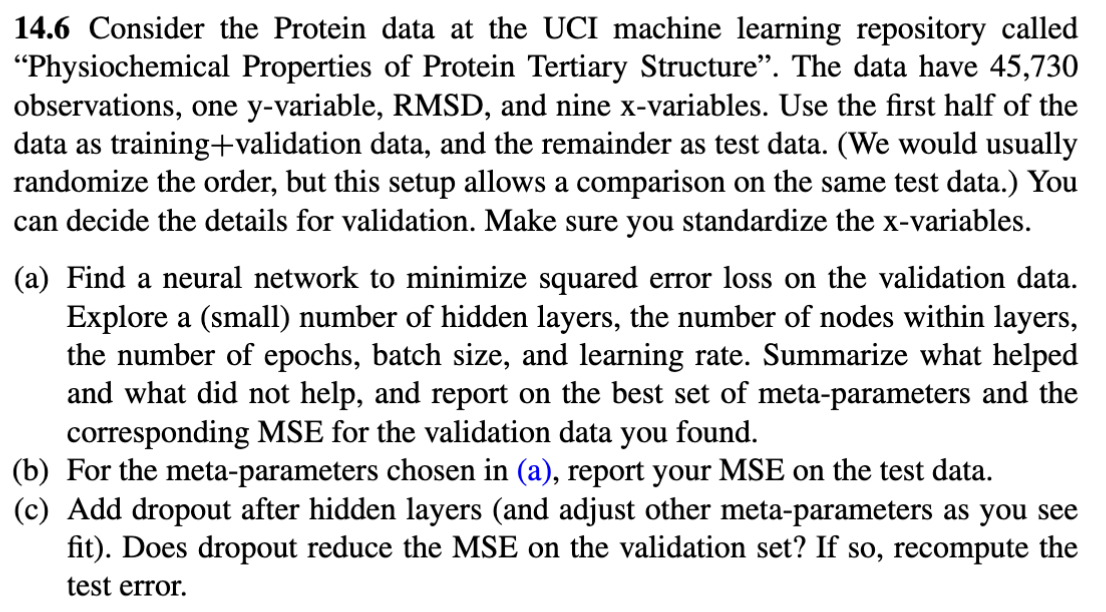

Loading libraries...

In [ ]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import math
import statistics
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# change the device to mps to accelerate training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

In [116]:
# read in the data
data = pd.read_csv("CASP.csv")
for i in data.columns[1:len(data.columns)]:
    # standardizing the variables
    data[i] = (data[i] - statistics.mean(data[i]))/statistics.stdev(data[i])

# extract the labels (first column)
labels = data["RMSD"]
# extract the data for prediction
df = data.loc[:,"F1":"F9"]
# convert the data to tensors
x_data = torch.tensor(data = df.values, dtype = torch.float32)
y_data = torch.tensor(data = labels.values, dtype = torch.float32)
# split into train/test
X_train = x_data[:len(data)//2]
X_test = x_data[len(data)//2:]
y_train = y_data[:len(data)//2]
y_test = y_data[len(data)//2:]
# split the training data into training and validation 
#   (assuming the ordering should still be maintained)
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20, shuffle = False)

### Part a)

Defining the neural network, "playing with layers" and meta-parameters.

In [117]:
# set the number of epochs, batch size, and learning rate
epochs = 1000
batch_size = 8
lr = 1e-5

Defining the NN class.

Here, I have it set up to where you can input variable sizes, as will be demonstrated in the training loop.

In [123]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [130]:
input_size = 9 
output_size = 1 
criterion = nn.MSELoss()
# to test the input of hidden layers
hidden_layers_config = [128] 
model = SimpleNN(input_size, hidden_layers_config, output_size).to(device)

SimpleNN(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
hidden_layers_configs = [[64], [128], [64, 64], [128, 128]]
batch_sizes = [8, 16]
learning_rates = [1e-4, 1e-5]  
epochs = 1000  
best_val_loss = float('inf')
patience = 10 
best_model_params = None
hyperparameters_log = []
for hidden_layers in hidden_layers_configs:
    for batch_size in batch_sizes:
        for lr in learning_rates:
            # reset the model
            model = SimpleNN(input_size, hidden_layers, output_size).to(device)
            # set the criterion and the optimizer
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # create the data loader
            train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
            valid_loader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=batch_size, shuffle=False)

            local_best_val_loss = float('inf')  # tracking the best lost for the config
            epochs_no_improve = 0 

            for epoch in range(epochs):
                model.train()
                for inputs, targets in train_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), targets)
                    loss.backward()
                    optimizer.step()
                
                # validation loop
                model.eval()
                with torch.no_grad():
                    val_loss = 0
                    for inputs, targets in valid_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        outputs = model(inputs)
                        val_loss += criterion(outputs.squeeze(), targets).item()
                    val_loss /= len(valid_loader)
                
                if val_loss < local_best_val_loss:
                    local_best_val_loss = val_loss
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_model_params = {
                            "hidden_layers": hidden_layers,
                            "batch_size": batch_size,
                            "learning_rate": lr,
                        }
                else:
                    epochs_no_improve += 1  # increment 
                    if epochs_no_improve >= patience:
                        print(f"Early stopping triggered after {epoch + 1} epochs.")
                        break  # early stop

                print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")
            
            # record parameters
            hyperparameters_log.append({
                "params": {
                    "hidden_layers": hidden_layers,
                    "batch_size": batch_size,
                    "learning_rate": lr,
                },
                "val_loss": local_best_val_loss
            })

# printing the best parameters
print(f"Best model parameters: {best_model_params}, with validation loss: {best_val_loss}")

So, our best model has 2 hidden layers, with 128 nodes, a batch size of 8, and a learning rate of 0.0001.

This leads to an $MSE_{\text{validation}} = 19.914560827237743$.

Since we don't save the model state, we retrain the model with the best parameters, this time going through every single epoch. 

In [ ]:
# create the data loader
batch_size = best_model_params["batch_size"]
hidden_layers = best_model_params["hidden_layers"]
lr = best_model_params["learning_rate"]
model = SimpleNN(input_size, hidden_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    
    # validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs.squeeze(), targets).item()
        val_loss /= len(valid_loader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")

So, after "fully training" the model using the best parameters as detailed above, we get $MSE_{\text{validation}} = 15.49317671191859$.

### Part b)

Evaluating on the test data. 

In [139]:
# create the test data set (since the training and validation are defined in the training loop)
#   due to the variable batch size depending on performance
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
# initialize a list to store predictions and true labels
predictions = []
true_labels = []

with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # forward pass
        outputs = model(inputs)
        # calculate the loss
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()
        # store preds/true values
        outputs = outputs.squeeze()
        if outputs.ndim == 0:
            predictions.append(outputs.item())
            true_labels.append(targets.item())
        else: 
            predictions.extend(outputs.tolist())
            true_labels.extend(targets.tolist())

# calculate mse on the test data
test_loss /= len(test_loader)


print(f"Mean Squared Error on Test Data: {test_loss}")


As we can see, we obtain $MSE_{\text{test}} = 16.434121215966833$.

### Part c)

Adding a dropout layer. 

The choice of $p = 0.25$ for the dropout layer is arbitrary here. 

In [152]:
class SimpleNNDropout(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.25):
        super(SimpleNNDropout, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU(), nn.Dropout(dropout_rate)]
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))  # add dropout after each activation
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
model = SimpleNNDropout(input_size, hidden_layers, output_size, dropout_rate = 0.25).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=batch_size, shuffle=False)
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    
    # validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs.squeeze(), targets).item()
        val_loss /= len(valid_loader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")

As we can see, we do get a marginal improvement in MSE: $MSE_{\text{dropout validation}} = 14.936854807646958$.

So, we compute the training error using dropout:

In [ ]:
# create the test data set (since the training and validation are defined in the training loop)
#   due to the variable batch size depending on performance
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

# initialize a list to store predictions and true labels
predictions = []
true_labels = []

with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # forward pass
        outputs = model(inputs).squeeze()
        # calculate the loss
        loss = criterion(outputs.squeeze(), targets.squeeze())
        test_loss += loss.item()
        # store preds/true values
        outputs = outputs.squeeze()
        if outputs.ndim == 0:
            predictions.append(outputs.item())
            true_labels.append(targets.item())
        else: 
            predictions.extend(outputs.tolist())
            true_labels.extend(targets.tolist())

# calculate mse on the test data
test_loss /= len(test_loader)


print(f"Mean Squared Error on Test Data: {test_loss}")

So, we get $MSE_{\text{dropout test}} = 15.5339203014704$ - an improvement over the previous MSE of $16.434121215966833$.